In [1]:
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

# Tutorial 4

Contents:
1. [Small-World model](#3.-Small-World-Model)



## 1. Small-World Model

The algorithm for generating a small-world network is as such:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We'll do these step-by-step first, and combine them into a function last.

### Create a ring of N nodes

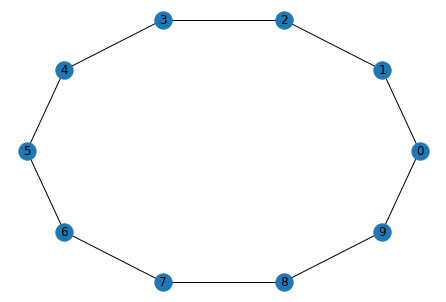

In [2]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)

In [3]:
print(nx.clustering(G))

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


### Connect each node to its $k$ nearest neighbors

We'll use modular arithmetic in order to do this. As an example of why, let's say $k$ is 4. So for node $n$, we want to add edges to $n$'s 4 nearest neighbors: $n-1, n+1, n-2,$ and $n+2.$ Since our nodes are in a circle, these can "wrap around", *e.g.* the 4 nearest neighbors of node 0 are N-1, 1, N-2, and 2.

Note the use of integer division (//) below. Integer division throws away the fractional part of division, e.g.

    5 // 2 = 2

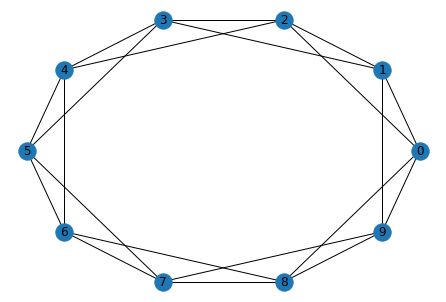

In [4]:
k = 4

for n in G.nodes:
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True)

{0: 0.6, 1: 0.6, 2: 0.6, 3: 0.6, 4: 0.6, 5: 0.6, 6: 0.6, 7: 0.6, 8: 0.6, 9: 0.6}


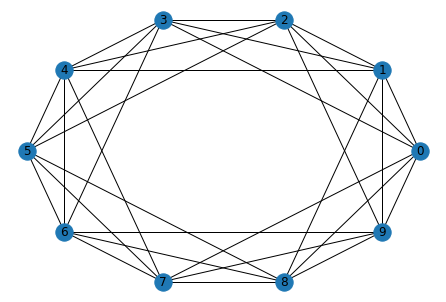

In [5]:
G = nx.watts_strogatz_graph(10,6,0.)
print(nx.clustering(G))
nx.draw_circular(G, with_labels=True)

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

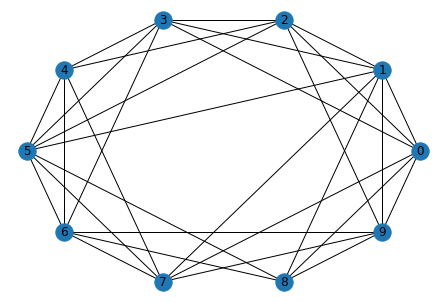

In [6]:
p = 0.1

for u, v in list(G.edges):
    if random.random() < p:
        not_neighbors = set(G.nodes) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True)

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [7]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

### NetworkX function

NetworkX has a function for this model: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

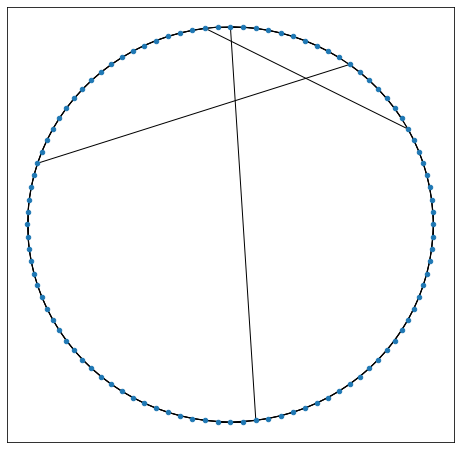

In [8]:
G = nx.watts_strogatz_graph(100,4,0.02)

pos = nx.circular_layout(G)
plt.figure(figsize=(8,8))
nx.draw_networkx(G,pos=pos,node_size=20,with_labels=0)

# Exercise   (5 pts)
Watts-Strogatz network with 100 nodes

o iterate over the range of the rewiring probabilty $ p \in [0,1]$ (use reasonable many steps in between)

o and compute the average shortest path length for all rewiring probabilty within this range (degree parameters $k=4$ and $k = 8$)

o plot both results in one figure with a legend 

o give both curves a customized color

o Estimate the asymptotic spl-value for $p\rightarrow1$ and plot them as dashed lines

In [18]:
df = pd.DataFrame(np.arange(0, 1, 0.005), columns=['propability'])
k_list = [4, 8]
for k in k_list:
    spl_list = []
    for probability in np.arange(0, 1, 0.005):
        G = nx.watts_strogatz_graph(200, 4, probability)
        spl_list.append(nx.average_shortest_path_length(G))
    df['k='+str(k)] = spl_list

In [27]:
df.iloc[-1:, 1:3]

,k=4,k=8
199,3.975126,4.019246


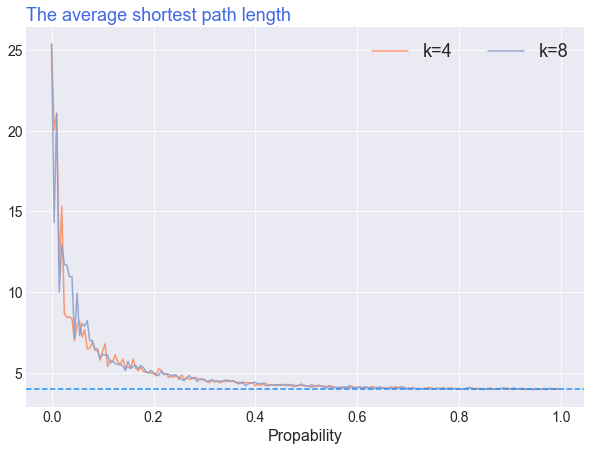

In [33]:
# Change the style and size of plot
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (10, 7)

# Create a color palette
palette = plt.get_cmap('Set2')

# Plot multiple lines
num = 0
for column in df.drop('propability', axis=1):
    num += 1
    plt.plot(df['propability'], df[column], marker='', color=palette(
        num), linewidth=1.5, alpha=0.9, label=column)

# Add legend
plt.legend(loc=1, ncol=2, fontsize=18)

# Add titles
plt.title("The average shortest path length", loc='left',
          fontsize=18, fontweight=0, color='royalblue')
plt.xlabel("Propability", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add dashed lines
#plt.axhline(y=3.975126, color='Orange', linestyle='dashed')
plt.axhline(y=4.019246, color='DodgerBlue', linestyle='dashed')

# Show the graph
plt.show()